# Modelação com XGBoost

Neste notebook vou aplicar o modelo XGBoost para tentar prever os resultados dos jogos da Liga Portuguesa.
O objetivo é treinar o modelo com dados até 2023 e testar na época 2023-2024.

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar Dataset
df = pd.read_csv('../Datasets/dataset_final_merged_v2.csv', low_memory=False)

# Converter Data
df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values('Data')

print(f"Total de jogos: {len(df)}")
df.head()

Total de jogos: 4425


C:\Users\diogo\AppData\Local\Temp\ipykernel_23328\2526675900.py:9: DtypeWarning: Columns (0,76,138) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Datasets/dataset_final_merged.csv')


,Div,Data,Equipa_Casa,Equipa_Visitante,Golos_Casa_Final,Golos_Visitante_Final,Resultado_Final,Golos_Casa_Intervalo,Golos_Visitante_Intervalo,Resultado_Intervalo,...,Away_hist_SaldoDeGolos+/-,Away_hist_SaldoDeGolos+/-Por90minutos,Away_hist_SaldoDeGolosEsperados+/-,Away_hist_SaldoDeGolosEsperados+/-Por90minutos,Away_hist_%DeDuelosAéreosGanhos,Away_hist_Golos,Away_hist_GolosSofridos,Away_hist_GolosEsperadosAssistidos,Away_hist_GolosEsperadosSemPenáltis,Away_hist_PassesProgressivos
0,P1,2010-08-13,Braga,Portimonense,3.0,1.0,H,2.0,0.0,H,...,0.0,0.0,0.0,0.0,0.0,0.0,50.666667,0.0,0.0,0.0
1,P1,2010-08-14,Marítimo,Vitória Setúbal,0.0,1.0,A,0.0,0.0,D,...,0.0,0.0,0.0,0.0,0.0,0.0,57.000000,0.0,0.0,0.0
2,P1,2010-08-14,Naval 1º de Maio,Porto,0.0,1.0,A,0.0,0.0,D,...,0.0,0.0,0.0,0.0,0.0,0.0,26.000000,0.0,0.0,0.0
3,P1,2010-08-14,Paços de Ferreira,Sporting CP,1.0,0.0,H,0.0,0.0,D,...,0.0,0.0,0.0,0.0,0.0,0.0,26.000000,0.0,0.0,0.0
4,P1,2010-08-15,Beira-Mar,União de Leiria,0.0,0.0,D,0.0,0.0,D,...,0.0,0.0,0.0,0.0,0.0,0.0,41.000000,0.0,0.0,0.0


In [2]:
# Criar Target (O que queremos prever)
# 0: Casa Vence, 1: Empate, 2: Visitante Vence
mapping_resultado = {'H': 0, 'D': 1, 'A': 2}
df['Target'] = df['Resultado_Final'].map(mapping_resultado)

# Remover jogos sem target (caso exista algum erro)
df = df.dropna(subset=['Target'])

In [3]:
# Seleção de Features (Apenas colunas numéricas conhecidas ANTES do jogo)
# Não podemos usar 'Golos_Casa_Final', 'Remates', etc., pois isso são stats do própio jogo.
# Vamos usar as Odds e as Stats Históricas (médias da época anterior).

features = [
    # Odds (o mercado 'sabe' muito)
#     'Odd_Casa_Bet365', 'Odd_Empate_Bet365', 'Odd_Visitante_Bet365',
    
    # Stats Históricas Casa
    'Home_hist_Pontos', 'Home_hist_GolosMarcados', 'Home_hist_GolosSofridos', 
    'Home_hist_xG', 'Home_hist_xGA', 'Home_hist_PosseDeBola',
    
    # Stats Históricas Visitante
    'Away_hist_Pontos', 'Away_hist_GolosMarcados', 'Away_hist_GolosSofridos',
    'Away_hist_xG', 'Away_hist_xGA', 'Away_hist_PosseDeBola',
    # Stats Forma (5 jogos)
    'Casa_Form_Pts5', 'Casa_Form_GM5', 'Casa_Form_GS5',
    'Visitante_Form_Pts5', 'Visitante_Form_GM5', 'Visitante_Form_GS5',
    'Casa_Form_Empates5',
    'Visitante_Form_Empates5',
    'Home_hist_GolosEsperados',
    'Home_hist_GolosEsperadosSofridos',
    'Away_hist_GolosEsperados',
    'Away_hist_GolosEsperadosSofridos',
    'Home_hist_PassesProgressivos',
    'Away_hist_PassesProgressivos',
    'Home_hist_JogosSemSofrerGolos',
    'Away_hist_JogosSemSofrerGolos'
]

# Filtrar colunas que realmente existem no DF (para evitar erros se faltar alguma)
features_existentes = [c for c in features if c in df.columns]
print(f"Usando {len(features_existentes)} features.")

X = df[features_existentes]
y = df['Target']

Usando 11 features.


In [4]:
# Divisão Treino / Teste (Temporal)
# Treino: Jogos antes de 01/08/2023
# Teste: Jogos depois de 01/08/2023 (Época 2023/24)

split_date = '2023-08-01'

mask_train = df['Data'] < split_date
mask_test = df['Data'] >= split_date

X_train = X[mask_train]
y_train = y[mask_train]

X_test = X[mask_test]
y_test = y[mask_test]

print(f"Treino: {len(X_train)} jogos")
print(f"Teste: {len(X_test)} jogos")

Treino: 3714 jogos
Teste: 711 jogos


In [5]:
# Grid Search para otimização de hiperparâmetros
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Modelo Base
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    seed=42
)

# Grelha de Parâmetros
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}

# Cross-Validation Temporal (para não misturar futuro com passado)
tscv = TimeSeriesSplit(n_splits=3)

# Configurar Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

# Executar Grid Search
print("Iniciando Grid Search...")
grid_search.fit(X_train, y_train)

# Melhores Parâmetros
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Melhor Score (CV): {grid_search.best_score_:.2f}")

# Usar o melhor modelo
model = grid_search.best_estimator_

Iniciando Grid Search...
Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\diogo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:199: UserWarning: [17:31:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores Parâmetros: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Melhor Score (CV): 0.56


Accuracy Treino: 0.57
Accuracy Teste: 0.57

Classification Report (Teste):
              precision    recall  f1-score   support

        Casa       0.55      0.88      0.68       300
      Empate       0.00      0.00      0.00       180
   Visitante       0.61      0.60      0.60       231

    accuracy                           0.57       711
   macro avg       0.38      0.49      0.43       711
weighted avg       0.43      0.57      0.48       711



C:\Users\diogo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\diogo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\diogo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_clas

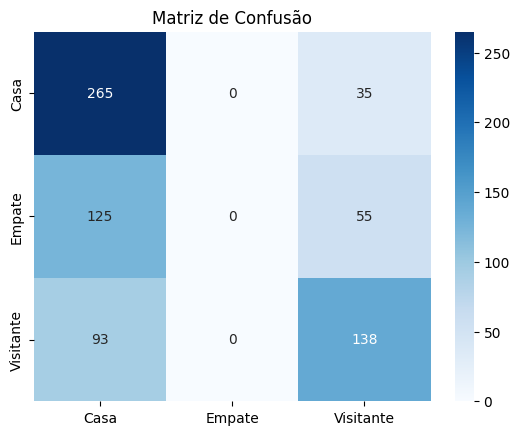

<Figure size 1000x600 with 0 Axes>

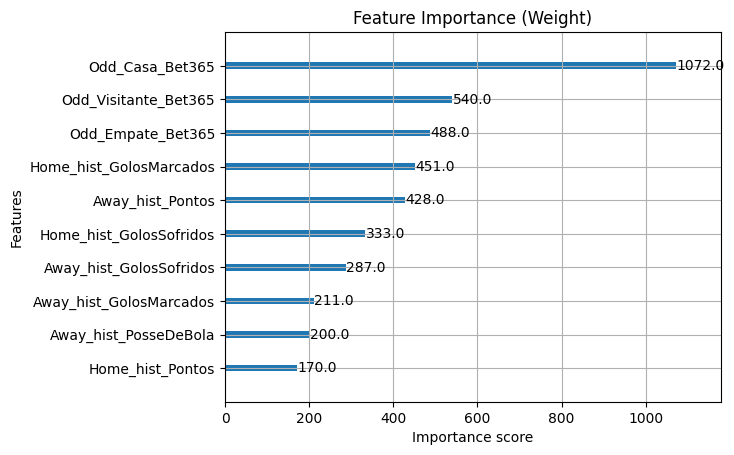

In [6]:
# Avaliação
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_pred)

print(f"Accuracy Treino: {acc_train:.2f}")
print(f"Accuracy Teste: {acc_test:.2f}")

print("\nClassification Report (Teste):")
print(classification_report(y_test, y_pred, target_names=['Casa', 'Empate', 'Visitante']))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Casa', 'Empate', 'Visitante'], yticklabels=['Casa', 'Empate', 'Visitante'])
plt.title('Matriz de Confusão')
plt.show()

# Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance (Weight)')
plt.show()